# ULI Treemaker v9


## Introduction
Aggregates all ULI data collected via excel sheet(s) provided to the ULI team at project kickoff. Data is viewable and traversable via a tree-type graph structure. Each node in the graph may have many children, but only one parent. 

### Changelog: 

#### v8 $\rightarrow$ v9

TODO: 
- None!

DONE: 
- Add VED
- Add normalized enthalpy (keyhole threshold metric)
- Add Gerber and Goodman criteria for fatigue
- Re-sort columns AFTER adding the functions listed in v8. 
- Added integer column for quantity of countours. 
- Add "part: has supports?" column with boolean value. 
- Updated LOF distance to be raw value instead of L2 penalty, as in v8.

#### v7 $\rightarrow$ v8

DONE: 
- Added multiple entries to variable resolution dictionary, such as skywriting, dosing, etc.
- Added convenience columns for hcf fatigue data, including mean stress, stress amplitude. 
- Added column for boolean lack of fusion criteria.
- Added column for an l2 penalty against exceeding the lof critical radius (i.e. 1). 

TODO: 
If a subsheet has no populated rows (e.g. no contour info, no support info, etc.) then offer to automatically populate the overall DataFrame with a boolean column for that sheet (e.g. Has: contour, Has: support) as False. 
Else True.

CMU01 - supports
CMU02 - supports
CMU03 - supports
CMU04 - supports
CMU05 - supports
CMU06 - supports
CMU07 - supports
CMU08 - supports
CMU09 - supports
CMU10 - supports
CMU11 - no supports
CMU12 - no supports
CMU14 - no supports
CMU15 - no supports
CMU16 - no supports

#### v6 $\rightarrow$ v7

Added more function documentation. 


#### v5 $\rightarrow$ v6 

Missing data handling added. Updates to Remove_NoVar_Columns() function. Now, columns are only removed from statistical analysis when they are both 1) fully populated, and 2) have only one unique value. A single nan in the column will cause it to be retained. This increases the number of retained columns dramatically for the ULI program.

For missing data, e-mails must be sent to the appropriate parties to obtain the data required to complete the original excel sheets. This way on the next load, the data will be current. 

Rules for ```None``` are SPECIFIC TO THIS NASAULI Project. 

ADDED: 
New function "Resolve_Conflicting_DataNames()"
Existing infrastructure handled naming conflicts within the header. 
Resolve_Conflicting_DataNames() receives a DataFrame, and a dictionary of dictionaries of the format:
{'ColumnName1':{'BadValue':'GoodValue'}}
The intent is to resolve issues such as "No" vs "NO" vs "n0"; "EOS M290" vs "EOSM290", etc.


A function (Add_ULI_None(df)) was built to address this ```None``` schema. See documentation for logic. 

A function (Add_ULI_NaN(df)) was built to address this NaN schema. See documentation for logic. 

#### v4 $\rightarrow$ v5

Interventions can now be made on each level of multi-index separately.

#### v3 $\rightarrow$ v4

Now with subtree aggregation as a separate processing step.

Now with enhanced name tokenization and user ability to intervene on unhelpfully-long variable names.


#### v2 $\rightarrow$ v3

Instead of v2 relying on strict hierarchy of UID/FID for processing (e.g. CMU01.1.SUP.IF.DF.C1.C2...), v3 now uses a dictionary-based parser that relies on the actual UID names. In other words, a UID ending in C1 will assume that the associated data sheet contains information about a contour pass. 

This comes with the drawback of having to standardize processing variable UIDs, however, the number of exceptions to parse without some support dictionary was quickly becoming untenable. 

### Misc. Notes: 

- For recursive functions, make sure the function returns itself along the stack. 
- Make sure the stopping conditions are correct. 

# Import Packages

In [1]:
import numpy as np
import networkx as nx # graph network
import pandas as pd
import re # regex

import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import plotly.express as px # plotting

from os import listdir
import os.path
from glob import glob
from functools import reduce
from pathlib import Path
from operator import itemgetter


# Function Bank

In [2]:
def Get_Box_Files(boxpath, quarantine_filelist=list([]), verbose=False):
    """
    Returns a list of all excel files from a box repository, recursively. 
    I.e. as seen in the ULI spreadsheet archive.
    
    boxpath = a pathname to a local sync folder using the box sync app. 
    
    quarantine_filelist
    
    
    """
    
    # Access files 
    files = list(glob(boxpath + '/**/*.xlsx', recursive=True))
    
    # Remove quarantined files
    if len(quarantine_filelist) > 0: 
        if verbose: 
            print("Removed quarantine files from search.")
        safe_files = [item for item in files if os.path.basename(item) not in quarantine_filelist]
    
    # Tag duplicate files for manual removal:
    if len(safe_files) != len(set(safe_files)):
        print("Duplicate filenames found in the master directory.\nVVVVV ~~~~~~ VVVVV")
        
        # Find quantity and identity of dupes.
        temparr = np.array(safe_files)
        unique, counts = numpy.unique(temparr, return_counts=True) 
        print([(item, counts) for item, counts in zip(unique, counts) if counts > 1])
        assert False, "^^^^^ Amend the above duplicated files before proceeding. ^^^^^\n"
    
    filedict = {os.path.basename(item):item for item in safe_files}
    
    assert len(filedict) > 0, \
    "The length of file list returned is zero. Check boxpath."
    
    return filedict

In [3]:
def Assemble_Master_Node_and_Edge_Lists(df_dict_dict, 
                                        sheetname_conflict_name_dict=dict(),
                                        group_conflict_name_dict=dict(), 
                                        variable_conflict_name_dict=dict(),
                                        context_conflict_name_dict=dict(), 
                                        units_conflict_name_dict=dict(),
                                        verbose=True):
    """
    Given a dictionary containing dictionaries of pandas DataFrames, 
    where each DataFrame represents the data from one excel file'sheets, 
    return a list of tuples in the format of NetworkX ebunches for node and edge lists. 
    
    Note: when pd.read_excel() is used on an excel file with more than 
    one sheet, a dictionary of pandas DataFrames is returned. The format of the argument 
    is just shorthand for named excel files. 
    
    Note2: Assemble_Master_Node_and_Edge_Lists asserts that all UIDs are unique 
    globally before it can successfully run. 
    
    Arguments:
        - df_dict_dict = A dictionary containing dictionaries of pandas DataFrames.
                         The top-level dictionary keys are typically the excel filename, e.g.:
                         "CMU01.xlsx", so the format of this dictionary looks generally like:
                         {"CMU01.xlsx":{"part":pd.DataFrame, 
                                        "infill":pd.DataFrame, 
                                        "foo":pd.DataFrame,
                                        ...
                                        "bar":pd.DataFrame},
                          "CMU02.xlsx":{"part":pd.DataFrame, 
                                        "infill":pd.DataFrame, 
                                        "foo":pd.DataFrame,
                                        ...
                                        "bar":pd.DataFrame},
                         ...
                          "EP07.xlsx":{"part":pd.DataFrame, 
                                       "infill":pd.DataFrame, 
                                       "foo":pd.DataFrame,
                                       ...
                                       "bar":pd.DataFrame}                                        
                          }
        - conflict_name_dict(s) = dictionaries of the format {"unwanted term":"replacement term"}
                                  each dictionary is separate because some terms that are helpful
                                  to one part of the multi-index header may be unhelpful to another. 
                                  Passing an empty dictionary (i.e. default argument) means that the 
                                  data will not be modified.
                                  
                                  NOTE: conflicting names are checked after name standardization using 
                                  Standardize_Varname(). 
                                  
        - verbose = prints the status of the parser as it iterates through each 
                    top-level dictionary, as well as each sub-dictionary, representing 
                    individual data sheets. 
    
    Returns:
    A two length tuple containing: (master_node_list, master_edge_list)
    
        - The format for the master_node_list is the NetworkX ebunch, i.e.:
          A list of two-length tuples, where each tuple is of the format:
          [('UID',{'UID':'foo', 'FID':'bar','power':123,...}), 
           ('UID',{...}), ...]
              
        - The format for the master_edge_list is the NetworkX standard list 
          of two-length tuples, where entry0=parent, and entry1=child, i.e.:
          [('CMU01', 'CMU01.01'),
           ('CMU01', 'CMU01.02'),
           ('CMU01', 'CMU01.03'),
           ...
           ('CMU01', 'CMU01.32')]


    Note: this function assumes the following format to excel sheets, typical of the NASAULI program: 
        - Row 0 = context and/or grouping for the variable names in row 1
        - Row 1 = variable names
        - Row 2 = additional descriptors for the variable name in row 1
                  e.g. (if row 1 is "thickness", then row 2 could be "transverse", "longitudinal", etc.)
        - Row 3 = units for the variable name in row 1. (e.g. mm, W, WaTtS, etc.)
        - Row 1, column 0 is UID
        - Row 1, column 1 is FID
        
    """
                         
    global_uid_list = []
    master_node_list = []
    master_edge_list = []
    # For each Excel filename 
    for df_dict_key in list(df_dict_dict.keys()):
        # For each sheet within that Excel file
        for sheet_key in df_dict_dict[df_dict_key].keys():
            if verbose: 
                print(f"Beginning to parse {df_dict_key} at {sheet_key}.")
            
            # Each sheet becomes a DataFrame
            df_dict = df_dict_dict[df_dict_key] # a single excel file
            tempdf = df_dict[sheet_key] # one sheet
            
            # Extract header information 
            # WARNING THESE RETURN np.NAN IF THE ENTRY IS EMPTY HAHA...
            group_info = tempdf.iloc[0,2:] 
            variable_names = tempdf.iloc[1,2:] 
            context_info = tempdf.iloc[2,2:]
            unit_names = tempdf.iloc[3,2:]
            
            # Extract data block
            data = tempdf.iloc[4:,:]

            # Clean variable names
            sheetname = Standardize_Varname(sheet_key)
            group_info = [Standardize_Varname(item) if not isinstance(item, float) else item for item in group_info]
            variable_names = [Standardize_Varname(item) if not isinstance(item, float) else item for item in variable_names]
            context_info = [Standardize_Varname(item) if not isinstance(item, float) else item for item in context_info]
            unit_names = [Standardize_Varname(item) if not isinstance(item, float) else item for item in unit_names]

            # Resolve naming conflicts among cleaned names. 
            # Note: CHANGE HERE FOR DIFFERENT CONFLICT DICTS FOR DIFFERENT PARAMS
            # Note: Conflicting Variable Names are fixed BEFORE the sheetname+groupname+variablename+context formatting
            # resolve things like "files" vs. "build files"
            group_info = [Check_Conflicting_Names(varname=item, 
                                                  conflict_dict=group_conflict_name_dict) for item in group_info]
            # resolve things like "support bulk power" vs "support power"
            variable_names = [Check_Conflicting_Names(varname=item, 
                                                      conflict_dict=variable_conflict_name_dict) for item in variable_names]
            
            # resolves things like 'ds' and 'L' in context names that even the subject matter
            # experts aren't confident with their inclusion
            context_info = [Check_Conflicting_Names(varname=item, 
                                                    conflict_dict=context_conflict_name_dict) for item in context_info]
            # resolves things like "wattts"
            unit_names = [Check_Conflicting_Names(varname=item, 
                                                  conflict_dict=units_conflict_name_dict) for item in unit_names]

            # sheetname coerced to same-size list of variable_names for ease of zipping
            sheetname = Check_Conflicting_Names(varname=sheetname, 
                                                conflict_dict=sheetname_conflict_name_dict)
            sheetnames = [sheetname]*len(variable_names)
            
            # Flatten the MultiIndex type arrangement in the Excel Sheets
            # Variable names become:
            # sheet_name + " " + group_info + " " +variable_name + " " + context_info
            # if any parts of the variable name are empty or nan, they are skipped
            varnames_no_uidfid = []
            for name_package in zip(sheetnames, group_info, variable_names, context_info):
                #######check for (and remove) np.nan's in the name##########
                temp_name_package = []
                for item in name_package:
                    if isinstance(item, float): # i.e. np.nan
                        assert np.isnan(item),\
                        f"A non np.nan float item was encountered at '{item}'"
                        # continue
                    else: 
                        temp_name_package.append(item)
                
                name_package=temp_name_package
                ############################################################
                
                #######remove duplicated words in variable name, assemble name_package#######
                # For each name_package:
                # If no duplicated words exist in variable name
                if len(name_package)==len(set(name_package)): 
                    # e.g.: "contour: hatch spacing ls"
                    formatted_name_package = Add_Colon(name_package)
                    new_varname = reduce(lambda x,y: x+" "+y, formatted_name_package)
                    addon = Standardize_Varname(new_varname)
                    varnames_no_uidfid.append(addon)
                # if conflict, use set in the order of name_package
                # e.g.: "contour contour hatch spacing ls"
                else: 
                    unduped_name_package = Remove_Duplicate_Entries(name_package)
                    formatted_name_package = Add_Colon(unduped_name_package)
                    formatted_unduped_varname = reduce(lambda x,y: x+" "+y, formatted_name_package)
                    addon = Standardize_Varname(formatted_unduped_varname)
                    varnames_no_uidfid.append(addon)
            ###################################################################################
            
            # varnames_no_uidfid now contains a list of all the flattened variable names
            # list addition retains order of arguments (i.e.: list(A)+list(B) != list(B)+list(A))
            full_varnames = ['UID', 'FID'] + varnames_no_uidfid
            
            # Add unit columns where populated
            # i.e. this has all units; keep only those for each row that have matching measurements
            unit_keys = [item[0]+" units=" for item in zip(varnames_no_uidfid, unit_names) if item[1]]
            unit_dict = {k:v for k,v in zip(unit_keys, unit_names)}
            
            # Assemble networkx ebunches for node and edge lists.
            # nodelist format is [('UID',{'UID':'foo', 'FID':'bar','power':123,...}), ('UID',{...}), ...]
            for row in range(data.shape[0]):
                temp_node_dict = dict()
                # Units are saved in the third row, not as their own column yet. 
                # zipping the variable names with the data creates a dict here that
                # has all the data, but no units as their own columns
                temp_node_dict = {k:v for k,v in zip(varnames_no_uidfid, data.iloc[row,2:])}
                
                # Add UID/FID 
                temp_node_dict.update({'UID':data.iloc[row,0],'FID':data.iloc[row,1]})
                
                # Now units are added
                temp_node_dict.update(unit_dict)
                
                # individual node ebunch is tuple of the form:
                # (nodename, {'things':'inside node',...})                
                uid_fid = (data.iloc[row,0], data.iloc[row,1]) # i.e.: (UID, FID)
                temp_nx_node = (uid_fid[0],temp_node_dict)
                
                assert uid_fid[0] not in global_uid_list, \
                f"The UID {uid_fid[0]} is duplicated! Amend before proceeding."
                
                global_uid_list.append(uid_fid[0])
                master_node_list.append(temp_nx_node)
                # NetworkX edges are of the form:
                # target, origin
                master_edge_list.append((uid_fid[1],uid_fid[0])) # i.e.: UID -> FID
                
    print("Bam! All Excel Sheets Have Been Parsed.")
    
    return (master_node_list, master_edge_list)

In [4]:
def Add_Colon(variable_namelist, token_mod_dict=None):
    """
    Helper function for ULI data. 
    CAN EASILY BE GENERALIZED TO MODIFY VARIABLE NAME TOKENS USING token_mod_dict. 
    
    Given a list of tokenized words that together make a variable name, 
    e.g.: ['contour', 'laser', 'spot', 'size', 'fwhm']
    
    returns ['contour:', ...]
    """
    if isinstance(variable_namelist, tuple):
        variable_namelist = list(variable_namelist)
    if token_mod_dict:
        assert False, "Not supported yet, please buy Alex a coffee."
    else:
        variable_namelist[0] = variable_namelist[0]+":"
        return tuple(variable_namelist)

In [5]:
def Check_Conflicting_Names(varname, conflict_dict, verbose=False):
    if verbose: 
        print(f"Conflicting name found at: {varname}.")
    if varname in conflict_dict.keys():
        varname = conflict_dict[varname]
        return varname
    else:
        return varname

In [6]:
def Remove_Duplicate_Entries(sequence):
    """
    Retains first instance of item in a sequence of potentially repeated values
    
    """
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

In [7]:
def Standardize_Varname(string, url_unsafe=True):
    """
    Standardizes the variable names in a dataset. 
    This function is typically applied to all 
    column headers, as well as each index in a multi-index. 
    
    What it does:
        - leading/trailing whitespace removed
        - words all lower case
        - no parentheses, brackets, or single quotes
        - multiple spaces between words reduced to one space
    
    Asserts that argument string is indeed a string. 
    
    Arguments:
        string = a string object representing a variable that needs cleaning. 
        url_unsafe = if True, performs operations such as str.lower() (urls are case-sensitive)
        
    Returns: 
        standardized string
    """
    assert isinstance(string, str), \
    f"Standardize_Varname(string) received a non-string agument at {string}."
    
    string = string.strip()
    
    # urls are case-sensitive.
    if url_unsafe:
        string=string.lower()
        
    string = re.sub(r"[]'[)(]+", 
                    repl="", 
                    string=string) # Brackets don't need escape within brackets
    string = re.sub(r"\s+", 
                    repl=" ", 
                    string=string)

    return string.strip()

In [8]:
def Is_Process_Condition(pc_pats, node):
    """Returns True if the target node name is a process condition, False otherwise.
    Arguments:
        pc_pats = a list of regex patterns that describe each process condition
            e.g.: [r"\.SUP$", r"\.4PB$",...]
        node = a node name to be checked for process condition status.
    
    """
    hits = []
    for pattern in pc_pats:
        hits.append(re.search(pattern=pattern, string=node, flags=re.I))

    return bool([item for item in hits if item])

In [9]:
def Return_Default():
    return None

In [10]:
def Safely_Append_Dict(base_dict, addon_dict, skip_id_keys=True, verbose=False, id_keys=None):
    """
    Asserts that no values for keys in base_dict are overwritten on update.
    If naming collisions occur, the keys for all collisions in addon_dict are modified with 
    the id_key suffix (e.g. .C1 or .DC2) and then appended. 
    
    Keys listed as id_keys are skipped during checks of naming collision. 
    
    Arguments:
        base_dict = the dictionary to be safely updated. 
        addon_dict = the dictionary to be added to base_dict.
    """    
    
    if skip_id_keys==True:
        try:
            uid_suffix = re.search(pattern=r".*\.(.*$)", 
                           string=addon_dict[id_keys[0]], # use the id_key from addon_dict to generate suffix
                           flags=re.I)[1]
        except TypeError:
            if verbose:
                print(f"Warning! No appropriate UID suffix at {addon_dict['UID']}. Appending 1 if necessary.")
            uid_suffix='1'
        addon_dict = {k:v for k,v in addon_dict.items() if k not in id_keys}
        if verbose:
            print(f"The UID suffix to be added upon name collision(s) is = {uid_suffix}")
    
    # Want name collisions to be the items in the addon_dict that exist in base_dict
    name_collisions = set(addon_dict.keys()).intersection(set(base_dict.keys()))
        
    try:
        assert len(name_collisions)==0, \
        f"Warning: Name Collisions found between base_dict and addon_dict at:\
        {name_collisions}"
    
        base_dict.update(addon_dict)
        return base_dict
    
    except AssertionError:
        if verbose:
            print(f"Duplicates detected at {name_collisions}. Appending UID suffix to all conflicts.")
        
        # Dictionary appending is done as a two-step process, first unique keys, then name collision keys
        if skip_id_keys==True:
            # Find unique keys to update
            safe_keys = set(addon_dict.keys()).difference(name_collisions)
            safe_vals = [addon_dict[key] for key in safe_keys]
            safe_addon_dict = {k:v for k,v in zip(safe_keys, safe_vals)}
            base_dict.update(safe_addon_dict)
            
            # Find collision keys to update
            unsafe_keys = set(addon_dict.keys()).difference(safe_keys)
            unsafe_vals = [addon_dict[unsafe_key] for unsafe_key in unsafe_keys]
            fixed_keys = [key+" "+uid_suffix for key in unsafe_keys]
            fixed_dict = {k:v for k,v in zip(fixed_keys, unsafe_vals)}
            base_dict.update(fixed_dict)
        else:
             assert 0==1, print("Not supported yet. Please update function.")
            
        return base_dict
        
        
        


In [11]:
def Name_Branches(graph, node):
    """
    Recursively climbs the process tree from leaf to root. 
    
    For each predecessor in the graph, if the parent exists, return this function called on the parent. 
    
    Note: 
    Used to check whether all nodes eventually point back to root. 
    """
    parent = [item for item in graph.predecessors(node)]
    if len(parent)>0 and parent[0]!=node:
        return Name_Branches(graph=graph, node=parent[0])
    else:
        return node

In [12]:
def Remove_nan_Entries(dictionary):
    """
    Checks whether each value in a dictionary is == 'nan', typecast as a string.
    Arguments: 
        - dictionary = a python dictionary, where some keys' values may be populated with "nan".
            - Note: This is solely because of how the excel sheets were filled. 
    Returns: 
        - dictionary, where only the keys with meaningful information (i.e. not "nan") are retained. 
    """
    tempdict = {k:v for k,v in zip(dictionary.keys(), dictionary.values()) if str(v)!='nan'}
    return tempdict

In [13]:
def Remove_NoVar_DF_Columns(df, verbose=False):
    """
    Remove columns that are fully populated *AND* have no variance (i.e. only one unique value).
    I.e. columns such as np.array([1, 1, NaN, 1, 1]) will remain. 
    
    Arguments: 
        - df = a pandas DataFrame
        
    Returns: 
        - df, with all fully-populated and no-variance columns removed. 
    
    """
    num_unique = [len(pd.unique(df.iloc[:,colnum]))>1 for colnum in range(len(df.columns))]
    
    colnames = [name for name, marker in zip(df.columns, num_unique) if marker]
    
    if verbose:
        droplist = set(df.columns).difference(set(colnames))
        print("Dropping columns: ", droplist)
    
    return df.loc[:,colnames]


# @@@@@@@@@ TEST DATAFRAME @@@@@@@@@
# testseries1 = np.empty(5)
# testseries1[:] = np.nan
# testseries2 = np.empty(5)
# testseries2[:] = None
# testseries2[3] = 1
# testdf = pd.DataFrame({'a':[1,2,np.nan,4,5], 
#                        'b':[1,1,1,1,1],
#                        'c':np.arange(5),
#                        'd':testseries1,
#                        'e':testseries2
#                       })
# testdf
# Remove_NoVar_DF_Columns(testdf, verbose=False) 




#     for colnum in range(df.shape[1]):
#         num_uniques = 
#         if verbose: 
#             print("Starting column: ", df.columns[colnum])
#             print(f"The number of unique entries in col={colnum} is: {len(uniques)}")   
        
        
#         if len(uniques)==1: # if only one unique value
#             num_nan_or_none = df.iloc[:,colnum].isnull().sum()
#             if len(uniques)==df.shape[0]: # and they are fully populated
#                 novar_cols.append(True) # mark as NoVar.
#             if num_nan_or_none==0: # But if no None or NaN values
#                 if verbose: 
#                     print("Column: ", df.columns[colnum]," has no nan or None (i.e. Null) entries.")
#                 novar_cols.append(True) # mark as NoVar
#         else:
#             print("Appending False to column: ", df.columns[colnum])
#             novar_cols.append(False) # else mark as column with variance
    
#     assert len(novar_cols)==len(df.columns), \
#     "The length of the marker list must be the same length as the number of df columns."
    
#     var_cols = [not item for item in novar_cols]
#     var_colnames = [item for item, marker in zip(df.columns, var_cols) if marker]
#     print("Varying colnames are: ", var_colnames)
#     temparr = df.iloc[:,var_cols]

#     tempdf = pd.DataFrame(temparr, columns=var_colnames)
#     tempdf.columns = tempcols

In [14]:
def Aggregate_Process_Condition_Subtrees(graph, pc_nodelist, verbose=True):
    """
    
    Returns: None
    Actions are performed inplace on the argument graph. 
    """
    for pc_node in pc_nodelist:
        parent_name = [item for item in graph.predecessors(pc_node)][0]
        Safely_Append_Dict(base_dict=graph.nodes[parent_name], 
                            addon_dict=graph.nodes[pc_node], 
                            skip_id_keys=True,
                            id_keys=['UID','FID'], 
                            verbose=verbose)
    if verbose: 
        print("Bam! Aggregation complete.")
    return None

In [15]:
# two ways: 
# start it with leaf dict and immediately safe copy
# start it with empty dict and change bool

# Used option 2: assumes holderdict is empty to begin
def Climb_Tree(graph, node, holderdict, _marker=False):
    """
    graph = graph
    node = leafnode
    holderdict = empty to begin
    _marker = internal helper boolean to avoid needless compute time
    """
#     print(f"Entering Climb_Tree({node})\n")
    if _marker==False:
        # Means that the argument dictionary is empty.
        holderdict.update(graph.nodes[node])
    else:
        name_collisions = set(holderdict.keys()).intersection(graph.nodes[node].keys())
        if len(name_collisions)==0:
            holderdict.update(graph.nodes[node])
        else:
            Safely_Append_Dict(base_dict=holderdict,
                                addon_dict=graph.nodes[node],
                                skip_id_keys=True,
                                id_keys=['UID','FID'])
    parent = [item for item in graph.predecessors(node)]
    if len(parent)>0:
        return Climb_Tree(graph=graph,
                          node=parent[0],
                          holderdict=holderdict,
                          _marker=True)
    else: 
        return holderdict   

In [16]:
def Resolve_Conflicting_DataNames(df, resolution_dictionary:dict, verbose=True, very_verbose=False) -> pd.DataFrame:
    """
    Resolve_Conflicting_DataNames(df, resolution_dictionary)
    A helper function for cleaning data. 
    Given a dataframe and a dictionary of dictionaries of conflicting and/or bad data, 
    return the same dictionary with the data entries replaced by their corresponding 
    "fixed" value. e.g.: {"Machine Name":{EOSM290":"EOS M290", "SLLM":"SLM"}}
    
    Arguments: 
        df = A Pandas DataFrame where columns represent different variables 
        and rows are observations of each variable. e.g. df.loc[:,'MyVariable1']
        
        resolution_dictionary = A dictionary of dictionaries whose top-level keys 
        are variable names, and the sub-dictionaries represent {BadData:GoodData} pairs. 
        e.g. {"Machine Name":{EOSM290":"EOS M290", "SLLM":"SLM"}}
        Offending keys are replaced with their corresponding value. 
    
    Returns:
        df
    """
    col_list = df.columns
    for colname in resolution_dictionary.keys():
        assert colname in col_list, \
        f"colname={colname} is not in arg df's column list. Amend before proceeding."
        
    for colname in resolution_dictionary.keys():
        if verbose: print(f"\n###### Cleaning column: {colname} ######\n")
        for offensive in resolution_dictionary[colname].keys():
            if very_verbose: print(f"Amending conflict for {offensive}->{resolution_dictionary[colname][offensive]}")
            df.loc[df.loc[:,colname]==offensive,colname]=resolution_dictionary[colname][offensive]

#     TEST CASE
# tempdict = {'Machine Name': {'EOSM290': 'EOS M290', "SLLM": 'SLM'}, 
#             'Location':{'Cornegie Mellin':'CMU', 'Carnegie Mellon':'CMU'}}
# Resolve_Conflicting_DataNames(pd.DataFrame({'Machine Name':[1, 2, 'EOSM290', 'EOS M290', 'SLM', 'SLLM'],
#                                             'Location':['Cornegie Mellin', 'CMU', 'CMU', 'CMU','Carnegie Mellon', 'CMU']}), 
#                               tempdict, verbose=True, very_verbose=True)
    return df

In [17]:
def Drop_Retests(df):
    """
    Argument df MUST CONTAIN columns for 'UID' and 'FID'
    
    Drops all rows from argument df where UIDs include the suffix "retest". 
    
    Returns: df with removed rows.
    """
    mask = [not bool(len(re.findall(pattern=r"retest", string=item))) for item in fatigue_df.loc[:,'UID']]
    return df.loc[mask,:]

In [18]:
def Reorder_df_Columns(df, orderlist=None):
    """
    Custom sorting pattern for the NASA ULI data. 

    Args: 
    df (pandas DataFrame): 
        A DataFrame to have the columns reordered for easier manipulation in gui-based programs like excel. 


    If orderlist==None:     
    Returns the argument dataframe with the column order as: 
        - UID
        - FID
        - Fill %
        - Alphabetical

    FUTURE WORK: 
    Else returns the argument dataframe the first len(orderlist) columns sorted as specified in orderlist. 
    """
    assert orderlist==None, "This feature is not supported yet."
    
    uidfid = ['UID', 'FID']
    othercols = list(set(df.columns).difference(set(uidfid)))
    num_filled = dict(df.notnull().sum()) # how many filled (i.e. not nan or None) values are in each column

    non_id_cols = [(item,num_filled[item]) for item in othercols]
    non_id_cols.sort(key=itemgetter(0)) # Sort on amount filled (0th tuple element)
    non_id_cols.sort(key=itemgetter(1), reverse=True) # Then backwars sort on alphabet
    col_order = [colname[0] for colname in non_id_cols]
    
    col_order = uidfid+col_order

    return df.loc[:,col_order]

    # orderlist (list): 
    #     A list of the first "p" entries in the argument df. 
    #     These first p-columns will be sorted by the order specified in the list. 
    #     All unspecified columns' order remains unchanged. 


# testseries1 = np.empty(5)
# testseries1[:] = np.nan
# testseries2 = np.empty(5)
# testseries2[:] = None
# testseries2[3] = 1
# testdf = pd.DataFrame({'a':[1,2,np.nan,4,5], 
#                        'b':[1,1,1,1,1],
#                        'c':np.arange(5),
#                        'd':testseries1,
#                        'e':testseries2
#                       })
# testdf['UID'] = None
# testdf['FID'] = None
# testdf

In [19]:
def Get_Line(p2, p1):
    """
    Given two points, returns m, b from y=mx+b
    """
    
    y2 = p2[1]
    y1 = p1[1]
    x2 = p2[0]
    x1 = p1[0]
    
    m = (y2-y1)/(x2-x1)
    # y = mx+b
    b = y1-m*x1
    
    return (m,b)

In [20]:
def Make_LOF_Space(laser_power, laser_speed, layer_thickness, hatch_spacing, return_threshval=True):
    """
    Transforms 
    Formulas for meltpool depth and meltpool width were extracted from the ULI Build Codex. 
    
    TODO: These were empirical? Asked Christian 3/9/2023 where these constants were found. 
    
    Formula uses the following units:
        Laser power = Watts
        Laser speed = mm/sec
        Layer thickness = mm
        Hatch spacing = mm
    
    return_threshval = LOF if this value is > 1. The more above 1, the worse "in" the LOF regime you operate.
    

    """
    
    p_over_v = laser_power / laser_speed

    mp_depth = 83*np.log(p_over_v)+194 # This is empirical?
    
    mp_width = 99.356*np.log(p_over_v)+320 # This is empirical?
    
    x = hatch_spacing*1000/mp_width # H/W
    y = layer_thickness*1000/mp_depth # L/D
    
    thresh = x**2 + y**2
    
    if not return_threshval:
        return (x,y)
    
    else:
        return (x,y,thresh)

# Load All Excel Files

In [21]:
quarantine_filelist = ["EP15 Build.xlsx", 
                       "Screen2.xlsx",
                       "CWRU-HCFAmplitude-CMU01.xlsx", # 20240502 - QUARANTINED UNTIL AUSTIN REPLY
                       "CWRU-HCFAmplitude-CMU02.xlsx", # 20240502 - QUARANTINED UNTIL AUSTIN REPLY
                       "CWRU-HCFAmplitude-CMU03.xlsx"  # 20240502 - QUARANTINED UNTIL AUSTIN REPLY
                       ]

In [45]:
macpath = "/Users/argon/Library/CloudStorage/Box-Box/ULI-share-among-team-members/Spreadsheets for Printing, Testing, Processing/Current_Spreadsheets"
winpath = r"C:\Users\alexg\Box\ULI-share-among-team-members\Spreadsheets for Printing, Testing, Processing\Current_Spreadsheets"

filedict = Get_Box_Files(boxpath = winpath, 
                         quarantine_filelist=quarantine_filelist, 
                         verbose=True)


Removed quarantine files from search.


In [46]:
df_dict_dict = dict()
for key,filepath in zip(filedict.keys(),filedict.values()):
    tempdf_dict = pd.read_excel(filepath, 
                                header=None, 
                                sheet_name=None)
    df_dict_dict[key] = tempdf_dict

In [47]:
print("Files loaded:", sorted(list(df_dict_dict.keys())))

Files loaded: ['CWRU-HCF-CMU01.xlsx', 'CWRU-HCF-CMU02.xlsx', 'CWRU-HCF-CMU03.xlsx', 'CWRU-HCF-CMU04.xlsx', 'CWRU-HCF-CMU05.xlsx', 'CWRU-HCF-CMU07.xlsx', 'CWRU-HCF-CMU08.xlsx', 'CWRU-HCF-CMU09.xlsx', 'CWRU-HCF-CMU10.xlsx', 'CWRU-HCF-CMU11.xlsx', 'CWRU-HCF-CMU16.xlsx', 'CWRU-HCF-EP04.xlsx', 'CWRU-HCF-EP05v2.xlsx', 'CWRU-HCF-EP07.xlsx', 'CWRU-HCF-NASA01.xlsx', 'CWRU-HCF-NASA02.xlsx', 'CWRU-HCF-NASA03.xlsx', 'Copy of CMU01.xlsx', 'Copy of CMU02.xlsx', 'Copy of CMU03.xlsx', 'Copy of CMU04.xlsx', 'Copy of CMU05.xlsx', 'Copy of CMU07.xlsx', 'Copy of CMU08.xlsx', 'Copy of CMU09.xlsx', 'Copy of CMU10.xlsx', 'Copy of CMU11.xlsx', 'Copy of CMU14.xlsx', 'Copy of CMU15.xlsx', 'Copy of CMU16.xlsx', 'EP04.xlsx', 'EP05v2.xlsx', 'EP07.SR.xlsx', 'EP07v2.xlsx', 'EP08.SR.xlsx', 'EP08v2.xlsx', 'NASA01.xlsx', 'NASA02.xlsx', 'NASA03.xlsx', 'NASAEP07v2.xlsx', 'PITT01.SR.xlsx', 'PITT01v2.xlsx', 'PITT02.SR.xlsx', 'PITT02v2.xlsx', 'PITTEP07v2.xlsx', 'ULI_Powder.xlsx']


### Here is where you manage naming conflicts
- encounters of of keys specified within flattened variable names are replaced with the corresponding value.


Note: 
A different option would be to have all values in the dictionary, but OK values just map to themselves. 

```python
def remap(name : str, conflicts : dict[str,str]) -> str:
# dict().get is equivalent to:
#     try 
#         return dict[key]:
#     except KeyError:
#         return default
    return conflicts.get(name, name)

```

In [48]:
sheetname_conflict_name_dict={"infill stripes":"infill",
                              "Support bulk":"support", 
                              "support bulk":"support",
                              "downskinfill no pattern":"downskinfill"}

group_conflict_name_dict={"filling":"", 
                          "files":"",
                          "specimen parameters":"",
                          "part variables":"",
                          "std. contour":"",
                          "contour":"",
                          "support":""}

variable_conflict_name_dict={"infill stripes":"infill", 
                             "contour offset":"offset", 
                             "speed":"scan speed",
                             "Bed Pre-heat t":"Bed Pre-heat",
                             "contour number":"number",
                             "support hatch":"hatch spacing",
                             "support power":"power",
                             "Support power":"power",
                             "Support velocity":"scan speed",
                             "support velocity":"scan speed",
                             "Support height":"height",
                             "support height":"height",
                             "Support diameter":"diameter",
                             "support diameter":"diameter",
                             "Support spacing":"spacing",
                             "support spacing":"spacing",
                             "note":"notes",
                             "notes general":"notes", # See CMU sheets, general is variable name, group name is notes
                             "general":"notes",
                             "width - chamfer, b":"chamfer width",
                             "thickness, d":"thickness",
                             "ϭmax":"stress max", # This is a Coptic letter P
                             "ϭmin":"stress min", # This is a Coptic letter P
                             "cycles to failure, nf":"cycles to failure", 
                             "hatch":"hatch spacing",
                             #"downskinfill: notes general":"downskinfill: notes", # Sanity check
                             "flow optimization":"flow optimized?", # Not sure where flow optimization is stored
                             "Machined to X finish":"Surface Machined Depth",
                             "infill hatch offset":"fill offset" # This is not always true, but is true for the ULI.
                            }

context_conflict_name_dict={"ds":"",
                            "IF":"",
                            "b":"",
                            "d":"",
                            "general":""}

units_conflict_name_dict={"mm/sec":"mm/s"}    

# Utility Cell: 
- Check for occurrence of a variable name within all spreadsheets for typo fixing

In [49]:
# problem_varname = 'flow optimization'

# for df_dict in df_dict_dict.values():
#     for key,df in df_dict.items():
#         targetset = set(df.loc[1,:])
#         # print(targetset)
#         if problem_varname in targetset:
#             print(f"Problem varname: {problem_varname} found in : {key}")

## Assemble Master Node and Edge List(s):

In [50]:
# tiny dict_dict for testing purposes
# testlength=10
# tinydict_dict = dict()
# testkeys = [key for key in df_dict_dict.keys()][:testlength]
# tinydict_dict.update({k:df_dict_dict[k] for k in testkeys})

master_node_list, master_edge_list = Assemble_Master_Node_and_Edge_Lists(\
                                          df_dict_dict=df_dict_dict,
                                          sheetname_conflict_name_dict=sheetname_conflict_name_dict,
                                          group_conflict_name_dict=group_conflict_name_dict, 
                                          variable_conflict_name_dict=variable_conflict_name_dict,
                                          context_conflict_name_dict=context_conflict_name_dict, 
                                          units_conflict_name_dict=units_conflict_name_dict,
                                          verbose=True)


Beginning to parse Copy of CMU01.xlsx at Build.
Beginning to parse Copy of CMU01.xlsx at Part.
Beginning to parse Copy of CMU01.xlsx at Infill.
Beginning to parse Copy of CMU01.xlsx at DownskinFill.
Beginning to parse Copy of CMU01.xlsx at Contour.
Beginning to parse Copy of CMU01.xlsx at DownSkinContour.
Beginning to parse Copy of CMU01.xlsx at Support.
Beginning to parse Copy of CMU02.xlsx at Build.
Beginning to parse Copy of CMU02.xlsx at Part.
Beginning to parse Copy of CMU02.xlsx at Infill.
Beginning to parse Copy of CMU02.xlsx at DownskinFill.
Beginning to parse Copy of CMU02.xlsx at Contour.
Beginning to parse Copy of CMU02.xlsx at DownSkinContour.
Beginning to parse Copy of CMU02.xlsx at Support.
Beginning to parse Copy of CMU03.xlsx at Build.
Beginning to parse Copy of CMU03.xlsx at Part.
Beginning to parse Copy of CMU03.xlsx at Infill.
Beginning to parse Copy of CMU03.xlsx at DownskinFill.
Beginning to parse Copy of CMU03.xlsx at Contour.
Beginning to parse Copy of CMU03.xlsx

## Clean the dictionaries:
- if a dictionary's value has a string datatype, clean it with Standardize_Varname
- if a dictionary's key:value is key:np.nan, remove the key

In [51]:
for entry in range(len(master_node_list)):
    tempuid = master_node_list[entry][0]
    tempdict = master_node_list[entry][1]
    for k,v in tempdict.items():
        if isinstance(v,str):
            fixed_v = Standardize_Varname(v, url_unsafe=False) # i.e.: won't try to format urls
            tempdict[k]=fixed_v
    tempdict = {k:v for k,v in tempdict.items()}
    master_node_list[entry] = (tempuid, Remove_nan_Entries(tempdict))

## Assemble Graph:

In [52]:
g1 = nx.DiGraph()
g1.add_nodes_from(master_node_list)
g1.add_edges_from(master_edge_list)

### Sanity check a node:

In [53]:
master_node_list[430]
#list(g1.successors("EP07v2.V94.1.SR.4PB"))
#list(g1.predecessors("EP07v2"))
#g1.nodes["EP07v2.V94.1.SR.4PB"]

('CMU08.01',
 {'part: scan order': 'IF,C2,C1',
  'part: moat': 'Yes',
  'part: downskin ridge': 5,
  'part: plate location x': 40,
  'part: plate location y': 213,
  'part: notes': '10mm moat',
  'UID': 'CMU08.01',
  'FID': 'CMU08',
  'part: plate location x units=': 'mm',
  'part: plate location y units=': 'mm'})

### View Full Graph (~30sec)

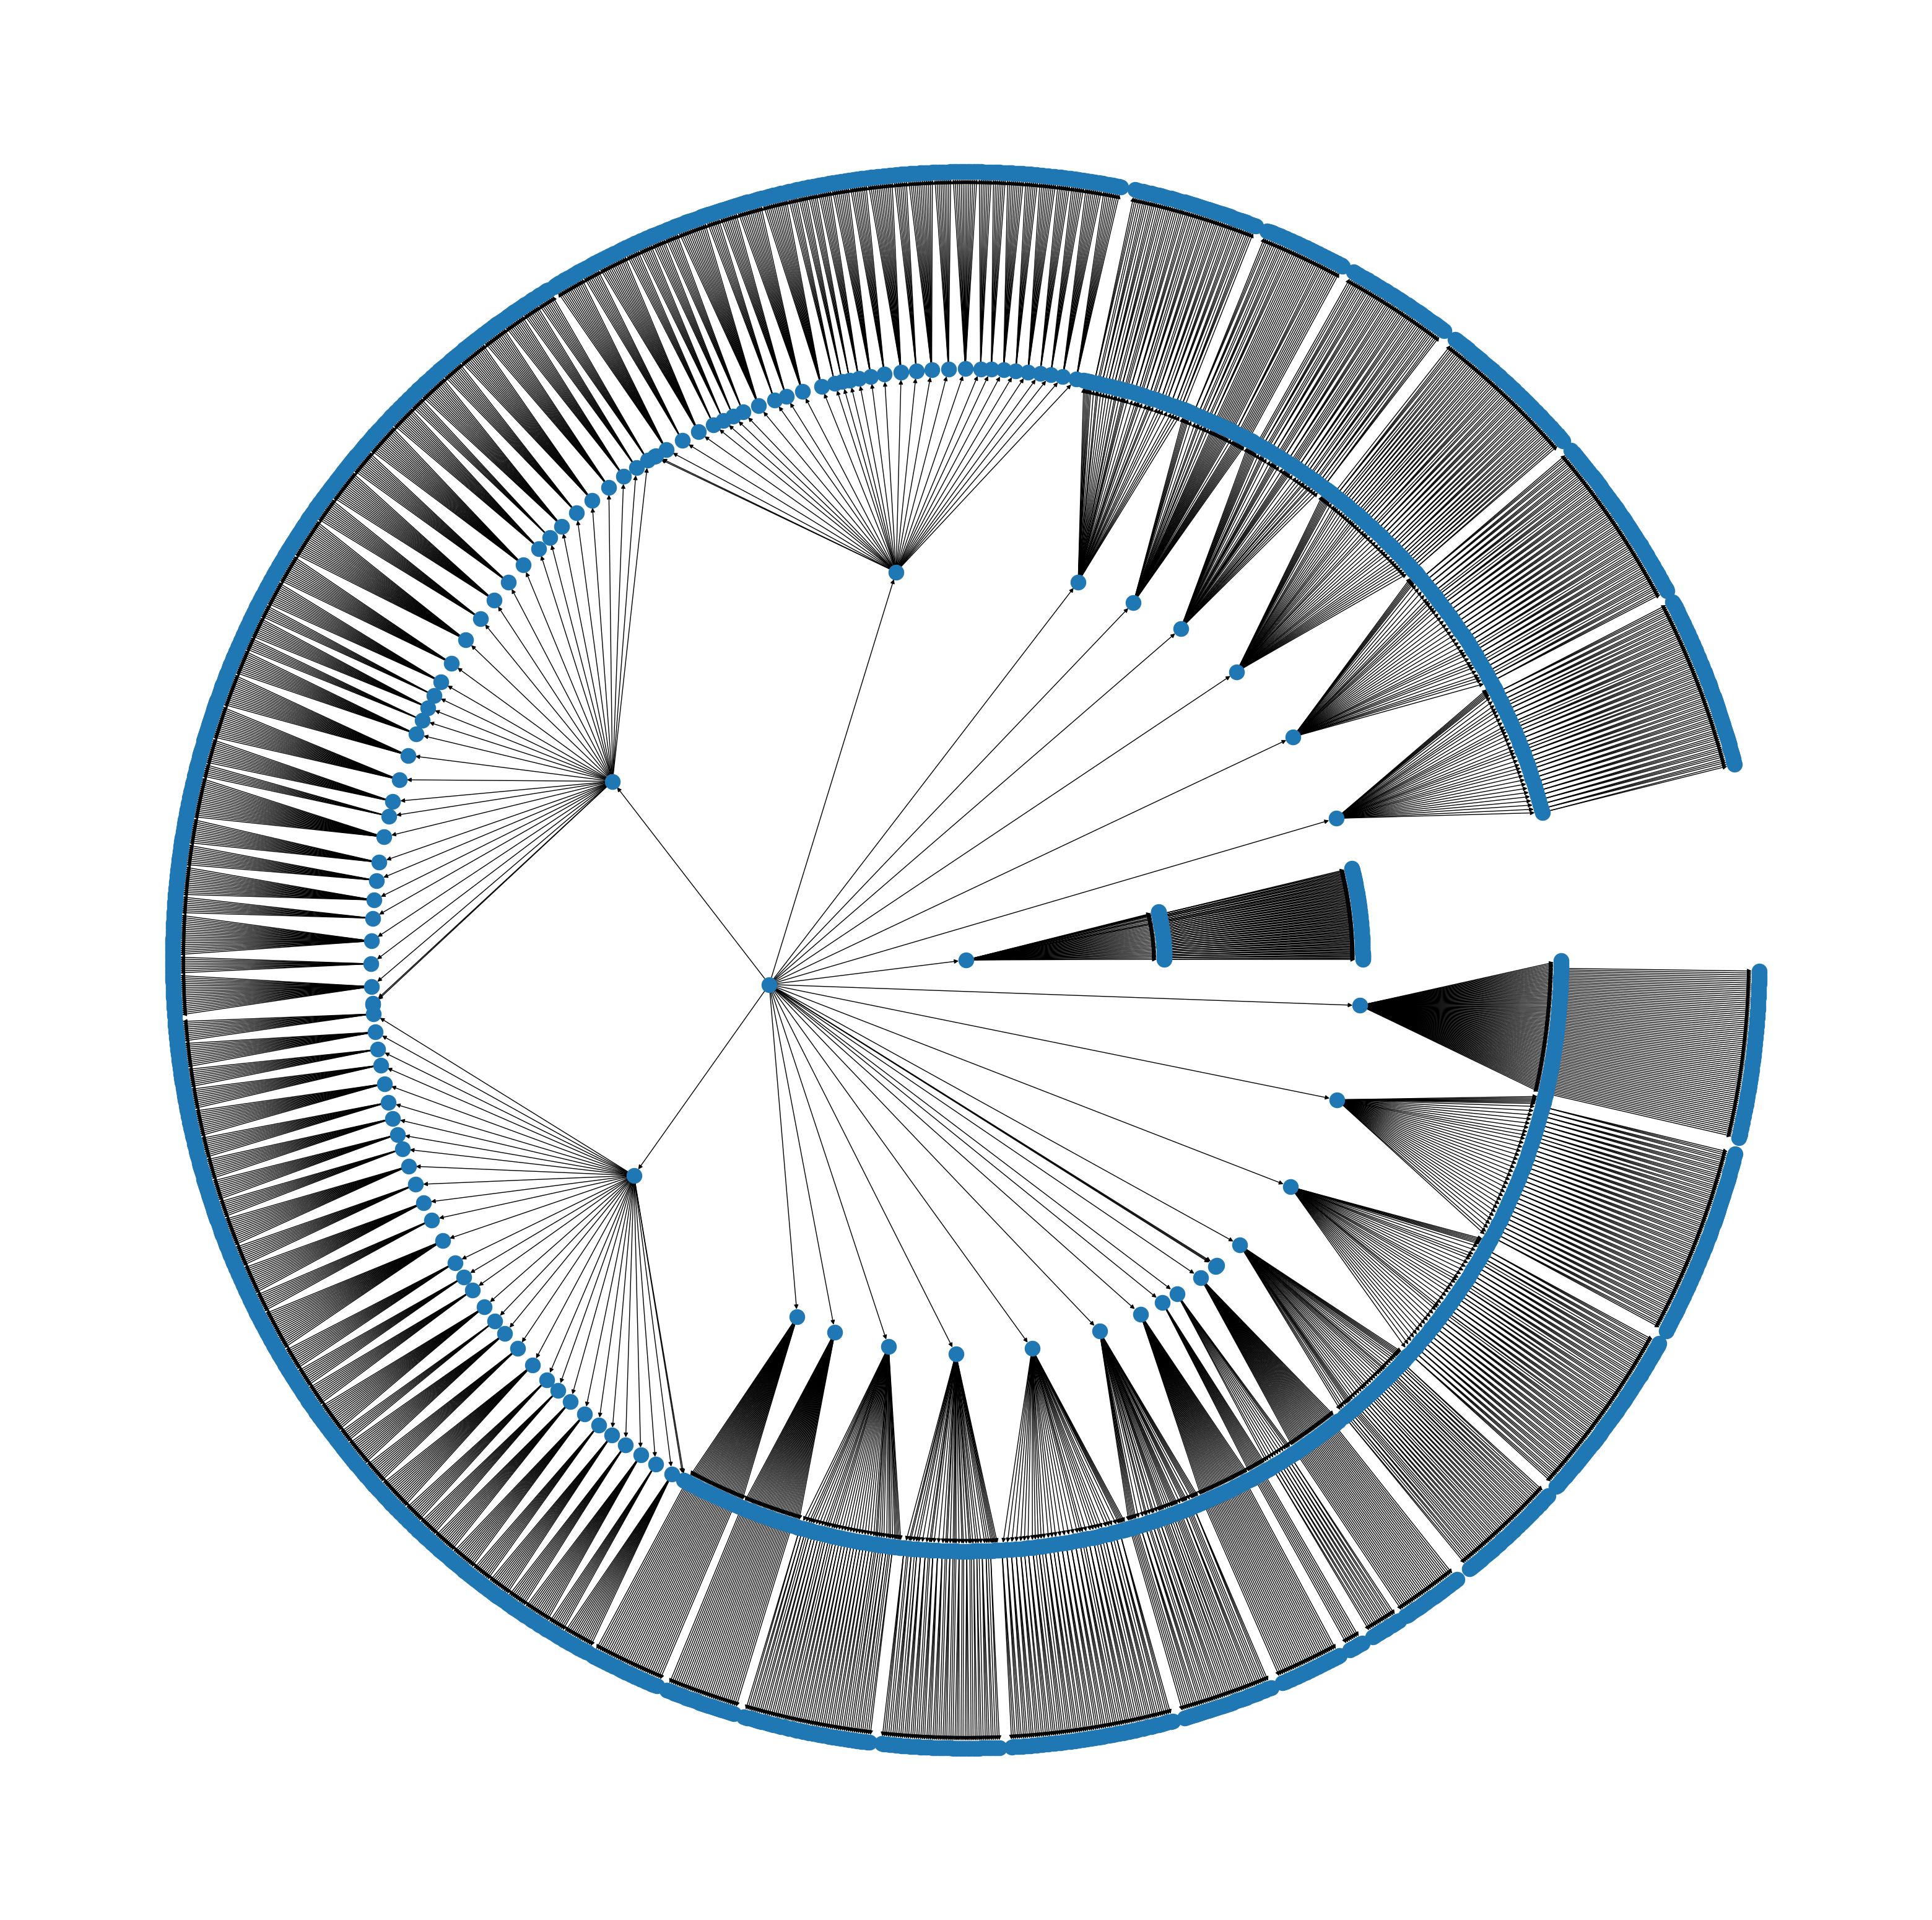

In [83]:
pos = nx.nx_agraph.graphviz_layout(g1, prog="twopi", args="") # prog="neato", "twopi"
# pos2 = nx.random_layout(g1) # because computers don't care how it looks to us. 

f1 = plt.figure(figsize=(40,40))
ax1 = f1.add_subplot(111)
nx.draw(g1.subgraph(list(nx.dfs_postorder_nodes(g1, 
                                                source="NASAULI", 
                                                depth_limit=None))), 
        with_labels=False, 
        ax=ax1, 
        pos=pos
        )

#plt.savefig('20240502-ULI_Data_Graph.png')

## Begin DataFrame Assembly:
- Step 0: Confirm the data meets assertion bank requirements. 
- Step 1: Subtree Aggregation (i.e. preload all process conditions)
- Step 2: Main Tree Aggregation

## Here is where you manage the UID/FID dictionary patterns: 

In [84]:
build_pattern = r"^(CMU|PITT|NASA)?(EP)?\d+(v)?\d+$"
part_pattern = build_pattern.replace("$", "")+r"\.(F|V|VE)?\d+$"
infill_pattern = r"\.IF$"
fatigue_pattern_4pb = r"\.((1|2)\.)?SR\.4PB$" # Axial is stored separately
fatigue_pattern_axial = r"\.((1|2)\.)?SR\.AX"
support_pattern = r"\.SUP$"
powder_pattern = r"\.PB[123]$"
contour_pattern = r"\.C\d+$"
downskin_contour_pattern = r"\.DC\d+$"
downskin_fill_pattern = r"\.DF(\d+)?$"
stress_relief_pattern = r"\.SR$" # no points occur after stress relief other than 4PB; r"SR\.[^4PB]" 
retest_pattern = r"retest" # retest anywhere in string

ct_pattern = r"\.CT(\d+)?$"
light_optical_microscopy_pattern = r"\.OM(\d+)?$"
ebsd_pattern = r"\.EBSD(\d+)?$"
sem_pattern = r"\.SEM(\d+)?$"
surface_scan_pattern = r"\.SURF(\d+)?$" # accounts for Zeiss via additional columns in that sheet for "e.g.: machine"
micro_eps_scan_pattern = r".MEPS(\d+)?$"
fracture_surface_img_pattern = r".FRAC(\d+)?$"


build_list = [item for item in g1.nodes if re.search(build_pattern, item, re.I)]
part_list = [item for item in g1.nodes if re.search(part_pattern, item, re.I)]
contour_list = [item for item in g1.nodes if re.search(contour_pattern, item, re.I)]
downskin_contour_list = [item for item in g1.nodes if re.search(downskin_contour_pattern, item, re.I)]
downskin_fill_list = [item for item in g1.nodes if re.search(downskin_fill_pattern, item, re.I)]
support_list = [item for item in g1.nodes if re.search(support_pattern, item, re.I)]
infill_list = [item for item in g1.nodes if re.search(infill_pattern, item, re.I)]
fatigue_list_4pb = [item for item in g1.nodes if re.search(fatigue_pattern_4pb, item, re.I)]
fatigue_list_axial = [item for item in g1.nodes if re.search(fatigue_pattern_axial, item, re.I)]
stress_relief_list = [item for item in g1.nodes if re.search(stress_relief_pattern, item, re.I)]
raw_powder_list = [item for item in g1.nodes if re.search(powder_pattern, item, re.I)]
retest_list = [item for item in g1.nodes if re.search(retest_pattern, item, re.I)]


### Confirm that all nodes are accounted for using the above patterns:

In [85]:
unaccounted = set().union(*[build_list, contour_list, 
                            part_list, downskin_contour_list, 
                            downskin_fill_list, support_list, 
                            infill_list, fatigue_list_4pb, 
                            fatigue_list_axial, stress_relief_list, 
                            raw_powder_list,['NASAULI'], retest_list])

# Any nodes listed here are in g1, but do not have a handler. 
unhandled = set(g1.nodes()).difference(unaccounted)
assert len(unhandled)==0, f"The following nodes are unhandled: {unhandled}."

### Confirm that all UIDs are unique
- Note: This is done during initial tree assembly by the __Assemble_Master_Node_and_Edge_Lists2()__ function.


### Confirm that all part parents are builds

In [86]:
unmatched_parts = [re.sub(pattern=r"\.(F|V|VE)?\d+$", 
                          repl="", 
                          string=item) for item in part_list if re.sub(pattern=r"\.(V|F|VE|)\d+", 
                                                                       repl="", 
                                                                       string=item) not in build_list]
assert len(unmatched_parts)==0, \
f"Some part data does not match standard naming convention: {unmatched_parts}"

### Confirm that all infill parents are parts or builds

In [87]:
unmatched_infills = [item for item in infill_list if re.sub(pattern=infill_pattern, repl="", string=item) not in part_list]
non_build_unmatched_infills = [item for item in unmatched_infills if re.sub(pattern=infill_pattern, repl="", string=item) not in build_list]
assert len(non_build_unmatched_infills)==0, \
f"Some infill data does not match standard naming convention: {non_build_unmatched_infills}"

# Infills that are not in parts:
# Note: EP08 is the only build where infill is the child of the build, not individual parts. 
# Manually edited to allow part descendence. 

### Confirm that all fatigue specimens match existing test specimen names:
- Note: included .1 and .2 in pattern, so both EP08.F01.1.SR.4PB and EP08.F01.2.SR.4PB will be checked.

In [88]:
unmatched_fatigues = [item for item in part_list if re.sub(pattern=r"\.((1|2)\.)?SR\.4PB", repl="", string=item) not in part_list]
assert len(unmatched_fatigues)==0, \
f"Some fatigue data does not match associated part names: {unmatched_fatigues}"

### Confirm that all support nodes' parents are builds or parts

In [89]:
unmatched_supports = [item for item in support_list if re.sub(pattern=support_pattern, repl="", string=item) not in build_list+part_list]

assert len(unmatched_supports)==0, \
f"Some support data does not directly descend from a build: {unmatched_supports}"


### Confirm that all raw powder inherits from NASAULI

In [90]:
unmatched_powder = [item for item in raw_powder_list if re.sub(pattern=powder_pattern, repl="", string=item) != 'NASAULI']

assert len(unmatched_powder)==0, \
f"Some raw powder data does not directly descend from NASAULI: {unmatched_powder}"

### Confirm that all contour data inherits from a build or a part. 

In [91]:
unmatched_contours = [re.sub(pattern=contour_pattern, repl="", string=item) for item in contour_list if re.sub(pattern=contour_pattern, repl="", string=item) not in part_list+build_list]

assert len(unmatched_contours)==0, \
f"Some contour data does not directly descend from a build or part: {unmatched_contours}"

### Confirm that all down skin contour data inherits from a build or a part

In [92]:
unmatched_downskin_contours = [item for item in downskin_contour_list if re.sub(pattern=downskin_contour_pattern, repl="", string=item) not in build_list+part_list]

assert len(unmatched_downskin_contours)==0, \
f"Some downskin contour data does not directly descend from a build: {unmatched_downskin_contours}"


### Confirm that all downskin fill parents are builds

In [93]:
unmatched_downskin_fills = [item for item in downskin_fill_list if re.sub(pattern=downskin_fill_pattern, repl=r"", string=item) not in build_list]

assert len(unmatched_downskin_fills)==0, \
f"Some downskin fill data does not directly descend from a build: {unmatched_downskin_fills}"


### Confirm that all stress relief parents are builds

In [94]:
unmatched_stress_reliefs = [item for item in stress_relief_list if re.sub(pattern=stress_relief_pattern, repl=r"", string=item) not in build_list]

assert len(unmatched_stress_reliefs)==0, \
f"Some stress relief data does not directly descend from a build: {unmatched_stress_reliefs}"

### Confirm that all data eventually points back to NASAULI

__NOTE:__ All parts labeled "retest" have been quarantined until guidance given!

In [95]:
pc_pats = [infill_pattern, support_pattern, 
           powder_pattern, contour_pattern, 
           downskin_contour_pattern, downskin_fill_pattern, 
           stress_relief_pattern, 
           # include reference to images for future work
           ct_pattern, 
           light_optical_microscopy_pattern, 
           ebsd_pattern, 
           sem_pattern, 
           surface_scan_pattern, 
           micro_eps_scan_pattern, 
           fracture_surface_img_pattern]


In [96]:
leaf_ends = []
for node in g1.nodes():
    leaf_ends.append((node,Name_Branches(g1, node)))

dangling_leaves = [f"(Leaf={item[0]}, Root={item[1]})" for item in leaf_ends if item[1]!="NASAULI"]
dangling_leaves = [item for item in dangling_leaves if not re.search(pattern=r"retest", string=item)]

assert len(dangling_leaves)==0, \
f"Not all leaves return to NASAULI! Amend:\n{dangling_leaves}"

In [97]:
# Sanity check for whatever "should" be above the broken parent connection.
#list(g1.predecessors('CMU10')) 

### Confirm no process condition nodes have children

In [98]:
pc_nodes = [node for node in g1.nodes() if Is_Process_Condition(pc_pats=pc_pats, node=node)]

In [99]:
for node in pc_nodes:
    children = [child for child in g1.successors(node)]
    assert len(children)==0, \
    f"Process condition node {node} has child {children}. PC nodes are one deep. Amend before proceeding."

## Perform Process Condition Subtree Aggregation:

In [100]:
Aggregate_Process_Condition_Subtrees(graph=g1, 
                                     pc_nodelist=pc_nodes, 
                                     verbose=True)

The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix to be added upon name collision(s) is = IF
The UID suffix

# Choose Which Type of Node to Aggregate Upon:

## Perform Main Tree Aggregation on 4 Point Bend Tests ONLY

In [101]:
fatigue_df_list_4pb = []
for fatigue_test in fatigue_list_4pb: # Note: No Axial Tests included here, because only aggregating on 4pb
    tempdict = Climb_Tree(graph=g1, node=fatigue_test, holderdict=dict())
    tempdf = pd.DataFrame.from_dict(tempdict,orient='index').T
    fatigue_df_list_4pb.append(tempdf)
print("\nBam! All rows have been added to the list.")


Bam! All rows have been added to the list.


In [102]:
fatigue_df = pd.DataFrame()
for row in fatigue_df_list_4pb:
    fatigue_df = pd.concat((fatigue_df,row)) # There has to be a faster way to do this. Try big dictionary?
print("\nMuch like the Justice League, the DataFrame has been assembled.")


Much like the Justice League, the DataFrame has been assembled.


## Drop all rows that were considered retests

In [103]:
fatigue_df = Drop_Retests(fatigue_df) 
# If we don't do this before removing novar columns, everything is kept haha. 

## Clean Data Entries, Resolve Duplicate Variable Meanings

In [104]:
master_data_conflict_dict = {'build: brand/model':{'EOSM290': 'EOS M290'},
                             'infill: flow optimized?':{'NO': False, 'N':False, "No":False}, 
                             'part: moat':{'Yes': True, 'No':False},
                             'infill: flow optimized? units=':{'y/n':"yes/no"}, 
                             'build: max dose':{200:2}, 
                             'build: min dose':{100:1}, 
                             'infill: skywriting':{"Auto":"Yes"},
                            }

In [105]:
fatigue_df = Resolve_Conflicting_DataNames(fatigue_df, 
                                           master_data_conflict_dict, 
                                           verbose=True,
                                           very_verbose=True)


###### Cleaning column: build: brand/model ######

Amending conflict for EOSM290->EOS M290

###### Cleaning column: infill: flow optimized? ######

Amending conflict for NO->False
Amending conflict for N->False
Amending conflict for No->False

###### Cleaning column: part: moat ######

Amending conflict for Yes->True
Amending conflict for No->False

###### Cleaning column: infill: flow optimized? units= ######

Amending conflict for y/n->yes/no

###### Cleaning column: build: max dose ######

Amending conflict for 200->2

###### Cleaning column: build: min dose ######

Amending conflict for 100->1

###### Cleaning column: infill: skywriting ######

Amending conflict for Auto->Yes


### Remove DataFrame columns without any variance. 
- Note: Any units columns that remain in the DataFrame imply a typo or a units mismatch that should be amended with high priority. 

In [106]:
fatigue_df = Remove_NoVar_DF_Columns(fatigue_df)

In [107]:
print(fatigue_df.shape)
display(fatigue_df.head())


(662, 332)


hcf 4-pt bend: start test date hcf 4-pt bend: operator team-staff  \
0            2021-10-04 00:00:00                           CWRU-AQN   
0            2021-10-04 00:00:00                           CWRU-AQN   
0            2021-10-18 00:00:00                           CWRU-AQN   
0            2021-10-19 00:00:00                           CWRU-AQN   
0            2021-12-06 00:00:00                           CWRU-AQN   

  hcf 4-pt bend: machine hcf 4-pt bend: load cell capacity  \
0                 10 kip                                44   
0                 10 kip                                44   
0                 10 kip                                44   
0                 10 kip                                44   
0                 10 kip                                44   

  hcf 4-pt bend: cyclic frequency hcf 4-pt bend: surface tested in tension  \
0                              20                                        3   
0                              20                                        3   
0                              20                                        3   
0                              20                                        3   
0                              20                                        3   

  hcf 4-pt bend: length hcf 4-pt bend: width hcf 4-pt bend: chamfer width  \
0                    74                 4.87                         3.92   
0                    74                 4.87                         3.92   
0                    74                 4.87                         3.92   
0                    74                 4.87                         3.92   
0                    74                 4.87                         3.92   

  hcf 4-pt bend: thickness  ... downskincontour: corridor units= DC2  \
0                     4.86  ...                                  NaN   
0                     4.86  ...                                  NaN   
0                     4.86  ...                                  NaN   
0                     4.86  ...                                  NaN   
0                     4.86  ...                                  NaN   

  downskincontour: thickness DC2 downskincontour: corridor DC2  \
0                            NaN                           NaN   
0                            NaN                           NaN   
0                            NaN                           NaN   
0                            NaN                           NaN   
0                            NaN                           NaN   

  downskincontour: thickness units= DC2 support: build: build interrupted  \
0                                   NaN      NaN                      NaN   
0                                   NaN      NaN                      NaN   
0                                   NaN      NaN                      NaN   
0                                   NaN      NaN                      NaN   
0                                   NaN      NaN                      NaN   

  build: chamber pressure set point downskincontour: notes support: files  \
0                               NaN                    NaN            NaN   
0                               NaN                    NaN            NaN   
0                               NaN                    NaN            NaN   
0                               NaN                    NaN            NaN   
0                               NaN                    NaN            NaN   

  support: files units=  
0                   NaN  
0                   NaN  
0                   NaN  
0                   NaN  
0                   NaN  

[5 rows x 332 columns]

## How filled is each remaining column, and how many unique values are there? 
- (Column name, number unique values, fill%: 1=100%)

In [108]:
fatigue_df = Reorder_df_Columns(fatigue_df)
[(col,len(pd.unique(fatigue_df.loc[:,col])),round(fatigue_df.loc[:,col].count()/fatigue_df.shape[0],2)) for col in fatigue_df.columns]


[('UID', 662, 1.0),
 ('FID', 367, 1.0),
 ('build: bed pre-heat t', 3, 1.0),
 ('build: brand/model', 2, 1.0),
 ('build: cover gas velocity set point', 2, 1.0),
 ('build: end date', 14, 1.0),
 ('build: location', 3, 1.0),
 ('build: max level o2 set point', 2, 1.0),
 ('build: rake blade material', 4, 1.0),
 ('build: start date', 15, 1.0),
 ('contour: number', 2, 1.0),
 ('contour: number C2', 2, 1.0),
 ('contour: offset', 14, 1.0),
 ('contour: offset C2', 14, 1.0),
 ('contour: power', 2, 1.0),
 ('contour: power C2', 4, 1.0),
 ('contour: scan speed', 2, 1.0),
 ('contour: scan speed C2', 2, 1.0),
 ('downskincontour: offset', 15, 1.0),
 ('downskincontour: power', 4, 1.0),
 ('downskincontour: scan speed', 3, 1.0),
 ('downskinfill: hatch spacing', 3, 1.0),
 ('downskinfill: power', 4, 1.0),
 ('downskinfill: scan speed', 2, 1.0),
 ('hcf 4-pt bend: chamfer width', 40, 1.0),
 ('hcf 4-pt bend: comments', 8, 1.0),
 ('hcf 4-pt bend: cycles to failure', 473, 1.0),
 ('hcf 4-pt bend: cyclic frequency', 1

## Plot Initial P-V Map to Check Loading Progress of Box

In [109]:
p2 = np.array([3050, 375]) # [3050,370]
p1 = np.array([0,0]) # [1200,150]

c2 = np.array([600,375])
c1 = np.array([0,0]) #[1200,150]

m1,b1 = Get_Line(p2,p1)
m2,b2 = Get_Line(c2,c1)

c:\Users\alexg\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alexg\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


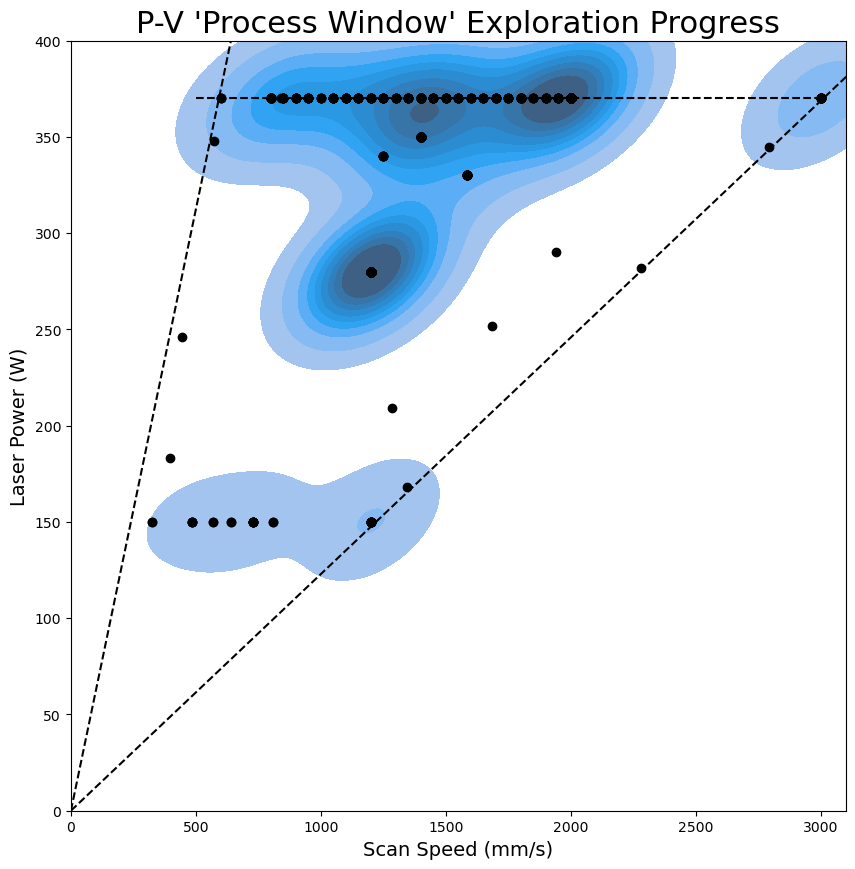

In [110]:
x = fatigue_df.loc[:,'infill: scan speed']
y = fatigue_df.loc[:,'infill: power']

f1 = plt.figure(figsize=(10,10))
ax1 = f1.add_subplot(111)

sns.kdeplot(x=x, 
            y=y, 
            ax=ax1, 
            fill=True)

ax1.scatter(x,
            y, color="black")

lower_left_grid = np.arange(0,2000,20)
lower_right_grid = np.arange(0,4000,20)

ax1.plot(lower_right_grid, m1*lower_right_grid+b1, 
         color="black",
         linestyle='--') # right border

ax1.plot(lower_left_grid, m2*lower_left_grid+b2, 
         color="black", 
         linestyle='--') # left border

ax1.hlines(y=370, 
           xmin=500, 
           xmax=3010, 
           color="black", 
           linestyle='--') # top border

ax1.set_xlim((0,3100))
ax1.set_ylim((0,400))

ax1.set_xlabel("Scan Speed (mm/s)", fontsize=14)
ax1.set_ylabel("Laser Power (W)", fontsize=14)
ax1.set_title("P-V 'Process Window' Exploration Progress", 
              fontsize=22)

plt.show()

# plt.savefig("20230807-PV_Window_Exploration_Data_Upload_Progress.png")

## De-Fragment the DataFrame
- This occured by calling ```pd.concat()``` many times in the loop above. 

In [126]:
fatigue_df = fatigue_df.copy()

## Add LOF Criteria Columns

In [127]:
lof_xyt = Make_LOF_Space(laser_power=fatigue_df.loc[:,"infill: power"].to_numpy(dtype="float"), # Watts
                         laser_speed=fatigue_df.loc[:,"infill: scan speed"].to_numpy(dtype="float"), # mm/sec
                         layer_thickness=np.array([30/1000]), # mm; assumed all layer thicknesses are 30
                         hatch_spacing=fatigue_df.loc[:,"infill: hatch spacing"].to_numpy(dtype="float"), # mm
                         return_threshval=True)
# saved as (x, y, thresh)


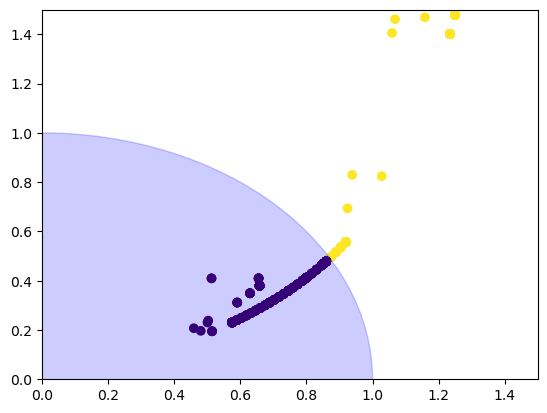

In [128]:
lof_fig = plt.figure()
lof_ax1 = lof_fig.add_subplot(111)

c1 = plt.Circle((0, 0), 1, color='b', alpha=0.2)

lof_ax1.scatter(lof_xyt[0],
                lof_xyt[1],
                c=lof_xyt[2]>1)

lof_ax1.add_patch(c1)
lof_ax1.set_xlim((0,1.5))
lof_ax1.set_ylim((0,1.5))
plt.show()

In [129]:
# Sanity Check
# list(zip(lof_xyt[2]>1,[round(item, 2) for item in lof_xyt[2]]))

In [130]:
lof_mask = [item>1 for item in lof_xyt[2]]
lof_l2_dist_penalty = [((item**2)-1)**2 if item>=1 else 0 for item in lof_xyt[2]]

In [131]:
fatigue_df["part: above_lof_criteria?"] = lof_mask
fatigue_df["part: lof_distance"] = lof_xyt[2] # also consider: lof_l2_dist_penalty

## Feature Engineering Via Additional Columns:

### $\sigma_{mean}$, $\sigma_{ampl}$, fatigue runout criterion, contour pass quantity, presence of supports

In [132]:
stress_range = (fatigue_df["hcf 4-pt bend: stress max"]-fatigue_df["hcf 4-pt bend: stress min"])/2
stress_range = stress_range.astype(float)
fatigue_df["hcf 4-pt bend: mean stress"] = np.round(stress_range,3)

stress_ampl = np.abs(fatigue_df["hcf 4-pt bend: stress max"]-fatigue_df["hcf 4-pt bend: stress min"])/2 # DIVIDE BY TWO FOR STRESS AMPLITUDE vs. STRESS RANGE.
stress_ampl = stress_ampl.astype(float)
fatigue_df["hcf 4-pt bend: stress amplitude"] = np.round(stress_ampl,3)

fatigue_df["hcf 4-pt bend: runout?"] = fatigue_df["hcf 4-pt bend: cycles to failure"]>=10000000

fatigue_df["part: number of contour passes"] = [len(re.findall(pattern=r",(C\d*)", string=item)) for item in fatigue_df.loc[:,"part: scan order"]]
fatigue_df["part: number of contours > 2?"] = fatigue_df["part: number of contour passes"] > 2

fatigue_df["part: has supports?"] = fatigue_df["support: hatch spacing"]>0 # Crude, but effective?


### The Goodman Criterion:

$$\sigma_{eff} = \frac{\sigma_{ampl}}{1-\frac{\sigma_{mean}}{\sigma_{UTS}}}$$ 

### The Gerber Criterion:

$$\sigma_{Gerber} = \frac{\sigma_{ampl}}{1-\left(\frac{\sigma_{mean}}{\sigma_{UTS}}\right)^2}$$


In [133]:
ti_64_uts = 900 # 950, 1170 # MPa @ BRICE WHICH ONE? 

goodman_denom = 1-(fatigue_df["hcf 4-pt bend: mean stress"] /ti_64_uts)
fatigue_df["hcf 4-pt bend: goodman criterion"] = np.round(fatigue_df["hcf 4-pt bend: stress amplitude"]/goodman_denom,3)


gerber_denom = 1-(fatigue_df["hcf 4-pt bend: mean stress"] /ti_64_uts)**2
fatigue_df["hcf 4-pt bend: gerber criterion"] = np.round(fatigue_df["hcf 4-pt bend: stress amplitude"] / gerber_denom,3)


### Four point bend bar: which half? 
- Most fatigue bars in the ULI were printed to be tall enough to section in half along an elevated X-Y plane and obtain two bars.
- The bottom half is either marked as ".1", or unmarked in the case of only the lower half being printed.
- The top half is marked as ".2"

In [134]:
# Portion of the four-point-bend bar that was sectioned (1=bottom, 2=top)
whichhalf = []
for item in fatigue_df["UID"]:
    result = re.findall(pattern=f".*\..*\.(1|2)",
                                string=item,
                                flags=re.I)
    if result: 
        result = int(result[0])
        whichhalf.append(result)
    else: 
        whichhalf.append(np.nan)
fatigue_df["hcf 4-pt bend: tophalf?"] = whichhalf


### Normalized Enthalpy & Keyhole Instability

Normalized Enthalpy, as introduced and developed by Rai et al. (2007), Hann et al. (2011), King et al. (2014) for welding and PBF-LB, is defined as: 

$$\frac{\Delta H}{h_s} = \frac{AP}{h_s\sqrt{\pi u D\sigma^3}}$$

Where: 
- $A$ = Absorptivity of Ti-6Al-4V to the appropriate wavelength of light. The ULI's machines were an EOS M290 and a SLM 280, both of which use a Yb laser of wavelength $\approx ~ 1.07 \mu m$. For Ti-6Al-4V, the absorptivity of this Yb sources is $0.27 \pm 0.03$ as described in Cook et al. (2023).
- $P$ = Laser power of the PBF-LB machine (W). 
- $u$ = Laser speed (m/s). 
- $D$ = Thermal diffusivity of the material $\frac{m^2}{s}$
- $\sigma$ = Spot size of laser (m). Assumes a Gaussian beam profile, and based on the full-width-half-max (FWHM). 
- $h_s$ = Enthalpy **at** melting (J/kg). Note that this is different than enthalpy **of** melting. (Rai et al. 2007)

In King (2014), $A$, $\rho$, $h_s$, and $D$ are treated as material constants, despite some of their temperature dependence. 

The keyhole criterion is achieved when the local maximum temperature attained by the moving laser source reaches the boiling point of the material and yields a keyhole whose depth to width ratio is large enough to become unstable as shown in King (2014) and reinforced in Zhao et al. (2020), Gordon et al. (2020). This causes a "pinching off" of the keyhole, yielding somewhat regularly spaced and spherical subsurface porosity. It was found that the normalized enthalpy $\frac{\Delta H}{h_s}$ can be used as a good threshold for predicting keyhole porosity when $\frac{\Delta H}{h_s}>\frac{\pi T_b}{T_m} \approx 6$, where $T_b$ is the boiling point of the material and $T_m$ is the melting point of the material. From Zhang et al. (2020), $T_b$ of Ti-6Al-4V is $~3133K$.

King (2014) mentions that this threshold is approximately six for most materials, and indeed for Ti-6Al-4V these values are reported by ASM as: $T_m = 1877.15$ to $T_m = 1933.15$ K, yielding a theoretical threshold of $\frac{\Delta H}{h_s} = (5.243, 5.091)$, respectively. However, King notes that for a powder layer thickness of $50$ $\mu m$, the actual keyhole threshold can be expressed as $\frac{\Delta H}{h_s} = 30 \pm 4$. It is unclear the reason for this discrepancy. 

King notes that the threshold is expected to depend powder layer thickness and (possibly) powder size distribution, but asserts that experimental evidence indicates that for the powder sizes and layer thicknesses typically used in LPBF, the change in threshold will be within the error bar. This is reinforced by numerical simulation conducted by Zhang et al. (2019), who found that Ti-6Al-4V powder bed absorption in selective laser melting was higher than 70% across multiple simulation cases. This absorptivity was found to vary with powder layer porosities and particle size distributions. Decreasing powder size increases light absorption, while decreasing powder porosity increases absorption. This yields at least a factor of $2$ difference from the $0.27\pm 0.03$ value chosen. 

Regardless of the specific threshold that is found to classify keyhole regimes, King indicates that past the threshold of $30$, "the scatter in the data increases significantly… \[and\] it indicates that the scatter is not solely due to variations in the melt pool depth along the length of the track and that the normalized enthalpy does not adequately capture the relevant physics with the smaller beam size above the keyhole threshold." This is helpful to note, as the intent of this work is to show that while not used a sole descriptor, the normalized enthalpy can be used in an ensemble that can more accurately describe the fatigue-based process window in PBF-LB materials. These results also reemphesize the importance of beam profiling and laser focus on PBF-LB part quality. 

Unit analysis: 
$$
\begin{align}
\frac{\Delta H}{h_s} &= \frac{AP}{h_s\sqrt{\pi u D\sigma^3}}\\
\frac{\Delta H}{h_s} &= \frac{(1)(J/s)}{(J/kg)\sqrt{(1) ( \frac{m}{s}) \frac{m^2}{s} (m)^3}}\\
\frac{\Delta H}{h_s} &= \frac{(1/s)}{(1/kg)\sqrt{(\frac{m}{s}) \frac{m^2}{s} (m)^3}}\\
\frac{\Delta H}{h_s} &= \frac{kg}{s\sqrt{ \frac{m^3}{s^2} (m)^3}}\\
\frac{\Delta H}{h_s} &= \frac{kg}{s\sqrt{ \frac{m^6}{s^2}}}\\
\frac{\Delta H}{h_s} &= \frac{kg}{s \frac{m^3}{s}}\\
\frac{\Delta H}{h_s} &= \frac{kg}{m^3}\\
\end{align}
$$




# WHY OFF BY A FACTOR? 

In [135]:
0.27*300/(1.12e6*np.sqrt(np.pi*1100*1.07e-5*(1e-4)**3)) # kg/m^3? from above

# To make unitless, divide by density? kg/m^3 / kg/m^3
# 4052 # kg/m^3 is density of Ti64 @ melting 1923K from Schmon et al. 2017
# 0.27*300/(1.12e6*np.sqrt(np.pi*1100*1.07e-5*(1e-4)**3)) / 4052.804
# 0.09280005366317454



376.1004286863284

In [136]:
# Add col for Normalized Enthalpy & Keyhole Instability
A_Ti64 = 0.27 # $\pm 0.03$ (Unitless); Cook et al. 2023 for Yb 1.07um laser
hs_Ti64 = 1.12e6 # (J/kg); Rai et al 2007
D_Ti64 = 1.07e-5 # (m^2/sec); Rai et al 2007
spotsize = 1e-4 # (m); I.e. a 100um spot size FWHM Gaussian profile.

normalized_enthalpy_numerator = A_Ti64*fatigue_df['infill: power'].astype(float)
normalized_enthalpy_denominator = hs_Ti64*np.sqrt(np.pi*fatigue_df['infill: scan speed'].astype(float)*D_Ti64*spotsize**3)                          
normalized_enthalpy = normalized_enthalpy_numerator/normalized_enthalpy_denominator
fatigue_df["infill: normalized enthalpy"] = np.round(normalized_enthalpy,3)

### Volumetric Energy Density

In [137]:
# Add column for VED (from Zhao et al. 2020)
ved_numerator = 4*fatigue_df["infill: power"]*(1-np.e**-2)
ved_denominator = np.pi*spotsize*fatigue_df["infill: scan speed"]
fatigue_df["infill: VED"] = ved_numerator/ved_denominator

# Save Raw DataFrame

In [138]:
fatigue_df.shape # sanity check

(662, 345)

In [125]:
fatigue_df_name = r"20240523-fatigue_df_v6.xlsx"
fatigue_df = Reorder_df_Columns(fatigue_df)
fatigue_df.to_excel(fatigue_df_name,
                    index=False)


# Workshop below: 

In [ ]:
# Shortlist for sorting columns
inscope_cols = [
    "UID", 
    "build: bed pre-heat t", 
    "build: brand/model",
    "build: cover gas velocity set point", 
    "build: location", 
    "build: max level o2 set point",
    "build: rake blade material",
    "contour: offset",
    "contour: offset C2",
    "contour: power",
    "contour: power C2",
    "contour: scan speed",
    "contour: scan speed C2",
    "downskincontour: offset",
    "downskincontour: power",
    "downskincontour: scan speed",
    "downskinfill: hatch spacing",
    "downskinfill: power",
    "downskinfill: scan speed",
    "hcf 4-pt bend: chamfer width",
    "hcf 4-pt bend: cycles to failure",
    "hcf 4-pt bend: machined to x finish",
    "hcf 4-pt bend: surface tested in tension",
    "hcf 4-pt bend: length", # for failure location distribution
    "hcf 4-pt bend: stress max",
    "hcf 4-pt bend: stress min",
    "hcf 4-pt bend: surface tested in tension",
    "infill: fill offset", 
    "infill: hatch spacing",
    "infill: power",
    "infill: scan speed",
    "part: moat",
    "part: plate location x",
    "part: plate location y",
    "part: rotation angle",
    "part: has support?"
]

len(inscope_cols)

In [ ]:
import alphashape
import matplotlib.cm as cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [ ]:
#%matplotlib qt
%matplotlib inline

In [ ]:
temparr = fatigue_df.loc[:,"hcf 4-pt bend: fail site from start/multiple initiation sites"]

breaklist = [item for item in temparr if np.logical_and(np.logical_or(isinstance(item,int), isinstance(item,float)),pd.notna(item))]

plt.hist(breaklist)
plt.xlabel("Fail Site from Start (mm)")
plt.ylabel("Number of 4PB Specimens")
plt.vlines(x=35, ymin=0, ymax=50, color="red")
plt.show()

# Knockdown Factor

In [ ]:
#fatigue_df.columns

# stress amplitude is bimodal
# cycles to failure are bimodal

alphashape_rowmask = fatigue_df.loc[:,'hcf 4-pt bend: cycles to failure']<1e7

In [ ]:
alphashape_columns = ['infill: scan speed','infill: power','infill: hatch spacing'] #  "'hcf 4-pt bend: cycles to failure'"

x = fatigue_df.loc[alphashape_rowmask,alphashape_columns[0]]
y = fatigue_df.loc[alphashape_rowmask,alphashape_columns[1]]
z = fatigue_df.loc[alphashape_rowmask,alphashape_columns[2]]

sa = np.log10(np.array(fatigue_df.loc[alphashape_rowmask, 'hcf 4-pt bend: stress max']-\
                       fatigue_df.loc[alphashape_rowmask, 'hcf 4-pt bend: stress min'],
                       dtype="float")/2)
max_stress = np.array(fatigue_df.loc[alphashape_rowmask, 'hcf 4-pt bend: stress max'],
                      dtype="float")

# Note: All R ratio values are 0.1
R_ratio = np.array(fatigue_df.loc[alphashape_rowmask, 'hcf 4-pt bend: stress min']/
                   fatigue_df.loc[alphashape_rowmask, 'hcf 4-pt bend: stress max'],
                   dtype="float")

tempitem = fatigue_df.loc[alphashape_rowmask,alphashape_columns]
bundled_xyz = [tuple(item) for item in tempitem.values]
alpha_shape = alphashape.alphashape(bundled_xyz, alpha=0.00000001) # smol alpha makes big circle. radius=1/alpha.

In [ ]:
colors = np.log10([float(item) for item in fatigue_df.loc[alphashape_rowmask,'hcf 4-pt bend: cycles to failure']])
im = plt.imshow(colors.reshape((-1,1)),aspect='auto');

## Add Keyhole Porosity Criteria

# Fatigue Life Figure
## MMPDS Vol 1, Chapter 5, Section 5.4
### From "Correlative Information for Figure 5.4.1.1.8(h)"


seq = max_stress*(1-0.1)**0.308 # Assumes that all R is 0.1 (Safe as of 20230315)

log_nf = 21.46-8.132*np.log10(seq)

In [ ]:
from sklearn.linear_model import LinearRegression as lr


In [ ]:
# ksi to mpa
ksi_to_mpa = 6.894757293

mmpds_mill_anneal_05in_meanline = pd.read_csv(r"C:\Users\alexg\OneDrive\Desktop\Mean Line.csv", 
                                              names=["Cycles to Failure",
                                                     "Max Stress (Ksi)"])

mmpds_mill_anneal_05in_sn = pd.read_csv(r"C:\Users\alexg\OneDrive\Desktop\R_0.1 Ti64 Unnotched Mill Annealed 0.5_ Thick Casting.csv", 
                                        names=["Cycles to Failure",
                                               "Max Stress (Ksi)"])

# Most comparable ustr to additive fabricated Ti64 to MMPDS is beta-annealed Ti64 (plate, forging, or casting) 
# TODO: Grab MMPDS casting
# TODO: Grab MMPDS forging





In [ ]:
temp_n = mmpds_mill_anneal_05in_sn.loc[:,'Cycles to Failure'].to_numpy(dtype="float")
temp_s = mmpds_mill_anneal_05in_sn.loc[:, 'Max Stress (Ksi)'].to_numpy(dtype="float")*ksi_to_mpa

temp_n = temp_n.reshape(-1, 1)
temp_s = temp_s.reshape(-1, 1)

sn_meanline = mmpds_mill_anneal_05in_meanline.to_numpy()
sn_meanline[:,1] = sn_meanline[:,1]*ksi_to_mpa

In [ ]:
log_grid = np.logspace(start=4.8, stop=7, num=100)

my_lr = lr()
my_lr.fit(np.log(temp_n), np.log(temp_s))

lr_pred = my_lr.predict(np.log(log_grid.reshape(-1, 1)))


seq = temp_s/ksi_to_mpa*(1-0.1)**0.308 # Assumes that all R is 0.1 (Safe as of 20230315)
log_nf = 21.46-8.132*np.log10(seq)
nf = np.power(log_nf, 10)

In [ ]:
plt.scatter(temp_n, temp_s)

plt.plot(sn_meanline[:,0],sn_meanline[:,1],c="orange") # Mean Line Reported in MMPDS
plt.plot(log_grid, np.exp(lr_pred), c="red") # Linear Regression Line

plt.plot(nf, seq*ksi_to_mpa, c="green") # MMPDS Line formula? KSI vs. MPa?????????????

plt.plot(log_grid, np.interp(x=log_grid, 
                             xp=sn_meanline[:,0], 
                             fp=sn_meanline[:,1]), c="magenta") # mmpds_mill_anneal_05in
plt.xscale("log")

In [ ]:
# E_density = power / vel * hatch * thickness
energy_density = fatigue_df.loc[alphashape_rowmask,"infill: power"] /(
                 fatigue_df.loc[alphashape_rowmask,"infill: scan speed"]/1000 * # convert mm/sec to m/sec
                 fatigue_df.loc[alphashape_rowmask,"infill: hatch spacing"]/1000 * # convert mm to m
                 0.03/1000 # universal layer thickness of 0.03mm in this ULI
                 )
energy_density = energy_density.to_numpy(dtype=float)

fl_xgrid = np.linspace(start=4, stop=7, num=100)

powerconst = 2.05
bottomstress = 2.4
left_pt = 4
fl_ygrid =  np.exp(-(fl_xgrid-left_pt)**powerconst)+bottomstress


In [ ]:
fl_fig = plt.figure()
fl_ax1 = fl_fig.add_subplot(111)

fl_ax1.scatter(x=np.log10(fatigue_df.loc[alphashape_rowmask,"hcf 4-pt bend: cycles to failure"].to_numpy(dtype="float")), 
               y=max_stress,
               c=lof_xyt[2][alphashape_rowmask]>1,
               s=energy_density/np.max(energy_density)*100)

# Plot MMPDS Mean Cast and shop anneal, 0.5" thick casting, Ti 6Al 4V fatigue life line, 
fl_ax1.plot(np.log10(log_grid), np.interp(x=log_grid, 
                                          xp=sn_meanline[:,0], 
                                          fp=sn_meanline[:,1]), 
            c="magenta")

#fl_ax1.plot(fl_xgrid, fl_ygrid)

fl_ax1.set_xlabel("Log10(cycles to failure)")
fl_ax1.set_ylabel("Max Stress (MPa)")

# fl_ax1.set_xlim((4, 7.5))
# fl_ax1.set_ylim((2, 3.3))

plt.show()

# Alphashape for Convex Hull
- Consider using Alphashape for independence distance and number of __distinguishable__ test scopes.

In [ ]:
from matplotlib.ticker import FormatStrFormatter

In [ ]:
# %matplotlib qt
%matplotlib inline

In [ ]:
axis_fontsize=14

f2 = plt.figure(figsize=(9,7))
ax2 = f2.add_subplot(111, projection="3d")

ax2.scatter(xs=x, 
            ys=y, 
            zs=z, 
            c=colors, 
            s=sa.reshape(-1)*15)

ax2.plot_trisurf(*zip(*alpha_shape.vertices), 
                 triangles=alpha_shape.faces, 
                 alpha=0.1)


ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.3f'))

#ax2.add_collection3d(Poly3DCollection([alpha_shape.coords]))
ax2.set_xlabel("Scan Speed (mm/s)", fontsize=axis_fontsize)
ax2.set_ylabel("Laser Power (W)", fontsize=axis_fontsize)
ax2.set_zlabel("Infill: Hatch Spacing", fontsize=axis_fontsize)

ax2.view_init(elev=35, azim=30)
f2.colorbar(mappable=im, ax=ax2, location="left", shrink=0.5)
ax2.set_title("PV-Hatch Diagram, Colored by Log10(Cycles to Failure)", fontsize=20)
ax2.view_init(azim=55)
plt.show()

## TODO: 
- More MMPDS Comparisons

# Scratchwork & Notes Below This Line:

In [ ]:
# def Tokenize_String(string, punctuation=False):
#     # [a-zA-Z0-9] also \S+    
#     tokens = [item for item in re.findall(pattern=r"(\b[a-zA-Z0-9_]+)+", string=string, flags=re.I)]
    
#     if punctuation: 
#         tokens = [item for item in re.findall(pattern=r"\b\S+", string=string, flags=re.I)]
    
#     return tokens

In [ ]:
# def Ensure_Equal_Lengths(a,b, pad=np.nan):
#     """
#     a,b = lists
    
#     """
#     lena = len(a)
#     lenb = len(b)
#     if lena==lenb:
#         return a,b
#     elif lena-lenb>0: # i.e. if a is longer
#         filler = [pad]*(lena-lenb)
#         return a, b+filler
#     else: # i.e. if b is longer
#         filler = [pad]*(lenb-lena)
#         return a+filler, b